# Test de connexion à la base de données

In [1]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine

# Informations de connexion à la base de données
host = 'postgres_dst' 
port = '5432'
database = 'dst_airlines_db'
user = 'dst_reader'
password = 'pass_reader'

# Connexion à la base de données
try:
    engine = create_engine(f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}')
    # Charger les données de la table dans un DataFrame pandas
    # Requête SQL explicite avec schéma et table
    # On élimine les vol annulés qui risque de polluer les estimations liés au retards et les 21 vols 'delayed'
    query_flight_info = 'SELECT * FROM l2.operations_customer_flight_info WHERE departure_actual_datetime IS NOT NULL AND arrival_actual_datetime IS NOT NULL'
    df = pd.read_sql_query(query_flight_info, con=engine)
    print("Connexion réussie et données flight_info chargées dans le DataFrame !")
    query_airports = 'SELECT * FROM l3.view_airports'
    view_airports = pd.read_sql_query(query_airports, con=engine)
    print("Connexion réussie et données airports chargées dans le DataFrame !")
    query_bird_strikes = 'SELECT * FROM l3.bird_strikes'
    bird_strikes = pd.read_sql_query(query_bird_strikes, con=engine)
    print("Connexion réussie et données bird_strikes chargées dans le DataFrame !")
except Exception as e:
    print("Erreur lors de la connexion ou du chargement des données :", e)



# Afficher les premières lignes du DataFrame pour vérifier
df.head()

Connexion réussie et données flight_info chargées dans le DataFrame !
Connexion réussie et données airports chargées dans le DataFrame !
Connexion réussie et données bird_strikes chargées dans le DataFrame !


,id,departure_airport_code,departure_scheduled_datetime,departure_estimated_datetime,departure_actual_datetime,departure_terminal_name,departure_terminal_gate,departure_status_code,departure_status_description,arrival_airport_code,...,arrival_actual_datetime,arrival_terminal_name,arrival_terminal_gate,arrival_status_code,arrival_status_description,operating_airline_id,operating_flight_nb,equipment_aircraft_code,overall_status_code,overall_status_description
0,95011,BRU,2024-07-19 10:50:00,None,2024-07-19 10:59:00,None,B33,DP,Flight Departed,LHR,...,2024-07-19 10:25:00,None,None,LD,Flight Landed,SN,2093,320,LD,Flight Landed
1,95012,DUS,2024-07-19 07:50:00,None,2024-07-19 08:06:00,None,A49,DP,Flight Departed,ATH,...,2024-07-19 12:57:00,None,None,LD,Flight Landed,EW,9680,32N,LD,Flight Landed
2,95013,BRU,2024-07-19 10:15:00,None,2024-07-19 10:27:00,None,A54,DP,Flight Departed,LIS,...,2024-07-19 11:08:00,None,None,LD,Flight Landed,SN,3815,320,LD,Flight Landed
3,95014,BRU,2024-07-19 10:25:00,None,2024-07-19 10:26:00,None,A40,DP,Flight Departed,MAD,...,2024-07-19 12:43:00,None,None,LD,Flight Landed,SN,3721,319,LD,Flight Landed
4,95015,BER,2024-07-19 08:55:00,None,2024-07-19 09:21:00,1,B12,DP,Flight Departed,HER,...,2024-07-19 14:16:00,None,None,LD,Flight Landed,4X,5382,320,LD,Flight Landed


# Décompte du nombre de portes et de terminaux par aéroports

In [2]:
import pandas as pd

# Filtrer les lignes avec des codes d'aéroports et des gates valides au départ
departures_gate = df[['departure_airport_code', 'departure_terminal_gate']].dropna()
departures_gate = departures_gate[departures_gate['departure_terminal_gate'] != '']

# Filtrer les lignes avec des codes d'aéroports et des gates valides à l'arrivée
arrivals_gate = df[['arrival_airport_code', 'arrival_terminal_gate']].dropna()
arrivals_gate = arrivals_gate[arrivals_gate['arrival_terminal_gate'] != '']

# Renommer les colonnes pour concaténer facilement
departures_gate = departures_gate.rename(columns={'departure_airport_code': 'airport_code', 'departure_terminal_gate': 'gate'})
arrivals_gate = arrivals_gate.rename(columns={'arrival_airport_code': 'airport_code', 'arrival_terminal_gate': 'gate'})

# Concaténer les départs et arrivées pour obtenir un DataFrame unique pour les gates
all_gates = pd.concat([departures_gate[['airport_code', 'gate']], arrivals_gate[['airport_code', 'gate']]])
unique_gates_per_airport = all_gates.drop_duplicates()

# Compter le nombre de gates uniques par aéroport
nb_gates_per_airport = unique_gates_per_airport.groupby('airport_code')['gate'].nunique().reset_index()
nb_gates_per_airport = nb_gates_per_airport.rename(columns={'gate': 'nb_gates'})

# Filtrer les lignes avec des codes d'aéroports et des terminaux valides au départ
departures_terminal = df[['departure_airport_code', 'departure_terminal_name']].dropna()
departures_terminal = departures_terminal[departures_terminal['departure_terminal_name'] != '']

# Filtrer les lignes avec des codes d'aéroports et des terminaux valides à l'arrivée
arrivals_terminal = df[['arrival_airport_code', 'arrival_terminal_name']].dropna()
arrivals_terminal = arrivals_terminal[arrivals_terminal['arrival_terminal_name'] != '']

# Renommer les colonnes pour concaténer facilement
departures_terminal = departures_terminal.rename(columns={'departure_airport_code': 'airport_code', 'departure_terminal_name': 'terminal'})
arrivals_terminal = arrivals_terminal.rename(columns={'arrival_airport_code': 'airport_code', 'arrival_terminal_name': 'terminal'})

# Concaténer les départs et arrivées pour obtenir un DataFrame unique pour les terminaux
all_terminals = pd.concat([departures_terminal[['airport_code', 'terminal']], arrivals_terminal[['airport_code', 'terminal']]])
unique_terminals_per_airport = all_terminals.drop_duplicates()

# Compter le nombre de terminaux uniques par aéroport
nb_terminals_per_airport = unique_terminals_per_airport.groupby('airport_code')['terminal'].nunique().reset_index()
nb_terminals_per_airport = nb_terminals_per_airport.rename(columns={'terminal': 'nb_terminals'})

# Fusionner les deux DataFrames sur la colonne airport_code
result = pd.merge(nb_terminals_per_airport, nb_gates_per_airport, on='airport_code', how='outer')

# Calculer le ratio gates_per_terminal quand nb_terminals et nb_gates sont valides
result['gates_per_terminal'] = result.apply(
    lambda row: row['nb_gates'] / row['nb_terminals'] if pd.notnull(row['nb_gates']) and pd.notnull(row['nb_terminals']) and row['nb_terminals'] > 0 else None,
    axis=1
)

# Extraire les dates de décollage les plus anciennes et les plus récentes
# Filtrer les données avec des dates de décollage valides
valid_departures = df[['departure_airport_code', 'departure_actual_datetime']].dropna()
valid_departures = valid_departures.rename(columns={'departure_airport_code': 'airport_code'})

# Calculer la date de décollage la plus ancienne et la plus récente pour chaque aéroport
departure_dates = valid_departures.groupby('airport_code')['departure_actual_datetime'].agg(
    oldest_departure='min', latest_departure='max'
).reset_index()

# Fusionner les informations de date avec le DataFrame result
result = pd.merge(result, departure_dates, on='airport_code', how='left')

# Extraire les dates d'atterrissages les plus anciennes et les plus récentes
# Filtrer les données avec des dates d'atterrissages valides
valid_arrivals = df[['arrival_airport_code', 'arrival_actual_datetime']].dropna()
valid_arrivals = valid_arrivals.rename(columns={'arrival_airport_code': 'airport_code'})
# Calculer la date d'atterrissage la plus ancienne et la plus récente pour chaque aéroport
arrival_dates = valid_arrivals.groupby('airport_code')['arrival_actual_datetime'].agg(
    oldest_arrival='min', latest_arrival='max'
).reset_index()

# Fusionner les informations de date avec le DataFrame result
result = pd.merge(result, arrival_dates, on='airport_code', how='left')

# Compter le nombre de vols au départ pour chaque aéroport
nb_departure_flight_total = df['departure_airport_code'].value_counts().reset_index()
nb_departure_flight_total.columns = ['airport_code', 'nb_departure_flight_total']

# Compter le nombre de vols à l'arrivée pour chaque aéroport
nb_arrival_flight_total = df['arrival_airport_code'].value_counts().reset_index()
nb_arrival_flight_total.columns = ['airport_code', 'nb_arrival_flight_total']

# Fusionner les données de vols de départ avec le DataFrame result
result = pd.merge(result, nb_departure_flight_total, on='airport_code', how='left')

# Fusionner les données de vols d'arrivée avec le DataFrame result
result = pd.merge(result, nb_arrival_flight_total, on='airport_code', how='left')

# Remplacer les NaN par 0 pour les aéroports qui n'ont pas de vols de départ ou d'arrivée
result[['nb_departure_flight_total', 'nb_arrival_flight_total']] = result[['nb_departure_flight_total', 'nb_arrival_flight_total']].fillna(0)

# Renommer AirportCode en airport_code pour correspondre à la clé de jointure avec result
view_airports = view_airports.rename(columns={
    'AirportCode': 'airport_code',
    'AirportNameFR': 'airport_name_FR',
    'AirportNameEN': 'airport_name_EN',
    'AirportLatitude': 'airport_latitude',
    'AirportLongitude': 'airport_longitude'
})

# Fusionner view_airports avec result sur airport_code
result = pd.merge(result, view_airports[['airport_code', 'airport_name_FR', 'airport_name_EN', 'airport_latitude', 'airport_longitude']], 
                  on='airport_code', how='left')

# Compter les occurrences de chaque type d'événement par aéroport
bird_strike_counts = bird_strikes.groupby(['airport_code', 'event_tag']).size().unstack(fill_value=0).reset_index()

# Renommer les colonnes selon le format demandé
bird_strike_counts = bird_strike_counts.rename(columns={
    'Accident': 'nb_bird_event_accident',
    'Incident': 'nb_bird_event_incident',
    'Report': 'nb_bird_event_report',
    'Crash': 'nb_bird_event_crash'
})

# Fusionner les données de bird_strike_counts avec le DataFrame result sur la colonne airport_code
result = pd.merge(result, bird_strike_counts[['airport_code', 'nb_bird_event_accident', 'nb_bird_event_incident', 'nb_bird_event_report', 'nb_bird_event_crash']], 
                  on='airport_code', how='left')

# Remplacer les valeurs NaN résultant de la fusion par 0, pour indiquer l'absence d'événements pour ces types
result[['nb_bird_event_accident', 'nb_bird_event_incident', 'nb_bird_event_report', 'nb_bird_event_crash']] = result[['nb_bird_event_accident', 'nb_bird_event_incident', 'nb_bird_event_report', 'nb_bird_event_crash']].fillna(0)


# Afficher le résultat final
print(result)

    airport_code  nb_terminals  nb_gates  gates_per_terminal  \
0            ABV           1.0       2.0                 2.0   
1            ACE           1.0       NaN                 NaN   
2            AGP           NaN      11.0                 NaN   
3            ALA           1.0       2.0                 2.0   
4            ALC           NaN       5.0                 NaN   
..           ...           ...       ...                 ...   
201          YYZ           1.0       6.0                 6.0   
202          ZAG           NaN       7.0                 NaN   
203          ZNZ           1.0       NaN                 NaN   
204          ZRH           NaN      90.0                 NaN   
205          ZTH           NaN       1.0                 NaN   

       oldest_departure    latest_departure      oldest_arrival  \
0   2024-07-06 23:14:00 2024-10-30 00:15:00                 NaT   
1   2024-07-07 17:51:00 2024-10-29 16:20:00 2024-07-07 09:15:00   
2   2024-07-06 19:49:00 2024-1

## Top 10 des aéroports avec le plus de gates

In [3]:
# Afficher les 10 aéroports avec le plus grand nombre de terminaux uniques
top_10_airports_gates = result.sort_values('nb_gates', ascending=False).head(10)

print("Top 10 des aéroports avec le plus de portes uniques :")
print(top_10_airports_gates)

Top 10 des aéroports avec le plus de portes uniques :
    airport_code  nb_terminals  nb_gates  gates_per_terminal  \
128          MUC           2.0     189.0           94.500000   
68           FRA           1.0     165.0          165.000000   
192          VIE           2.0     116.0           58.000000   
57           DUS           NaN      90.0                 NaN   
204          ZRH           NaN      90.0                 NaN   
17           BER           1.0      81.0           81.000000   
34           BRU           NaN      73.0                 NaN   
64           FCO           1.0      50.0           50.000000   
175          STR           3.0      47.0           15.666667   
80           HAM           2.0      43.0           21.500000   

       oldest_departure    latest_departure      oldest_arrival  \
128 2024-07-05 13:45:00 2024-10-31 00:01:00 2024-07-06 06:08:00   
68  2024-07-05 15:31:00 2024-10-30 23:30:00 2024-07-06 06:07:00   
192 2024-07-05 14:33:00 2024-10-31 00:28

## Détails des gates pour un aéroports

In [4]:
# Filtrer pour ne garder que les lignes où airport_code est "MUC"
muc_gates = unique_gates_per_airport[unique_gates_per_airport['airport_code'] == 'MUC']

# Afficher les terminaux uniques pour l'aéroport "MUC"
print("Portes pour l'aéroport MUC :")
print(muc_gates['gate'].unique())

# Filtrer pour ne garder que les lignes où airport_code est "CDG"
cdg_gates = unique_gates_per_airport[unique_gates_per_airport['airport_code'] == 'CDG']

# Afficher les terminaux uniques pour l'aéroport "MUC"
print("Portes pour l'aéroport CDG :")
print(cdg_gates['gate'].unique())

Portes pour l'aéroport MUC :
['G24' 'K27' 'G28' 'G35' 'H34' 'L11' 'G64' 'G82' 'G27' 'G33' 'G18' 'K16'
 'G71' 'G47' 'G65' 'G31' 'G41' 'K22' 'G63' 'G81' 'G17' 'K08' 'L13' 'K12'
 'L15' 'G19' 'G11' 'G66' 'G69' 'G30' 'K03' 'K14' 'D12' 'K18' 'G29' 'K04'
 'H40' 'A16' 'A21' 'G72' 'G70' 'G34' 'K07' 'G20' 'A26' 'G08' 'A14' 'G40'
 'G37' 'H38' 'D06' 'L21' 'H44' 'G44' 'H46' 'G39' 'H30' 'L10' 'H32' 'K30'
 'G48' 'G10' 'H37' 'G32' 'K09' 'L30' 'H16' 'G26' 'L26' 'H26' 'H39' 'L01'
 'G07' 'L03' 'L06' 'K05' 'K10' 'G16' 'G14' 'K25' 'H14' 'H20' 'K19' 'K21'
 'L19' 'H24' 'G46' 'H35' 'H48' 'H33' 'G02' 'H19' 'K26' 'H28' 'H08' 'G38'
 'K15' 'H12' 'K01' 'L09' 'K20' 'L25' 'K23' 'L08' 'H18' 'H45' 'K11' 'K13'
 'G04' 'L22' 'K06' 'G23' 'L07' 'G15' 'G06' 'G84' 'K24' 'G13' 'G43' 'G01'
 'L27' 'G03' 'G05' 'H02' 'G09' 'L24' 'L28' 'H41' 'K28' 'H04' 'G36' 'H27'
 'G45' 'L23' 'G42' 'G22' 'L05' 'H29' 'H47' 'L04' 'G12' 'H06' 'H42' 'H05'
 'H01' 'H15' 'H23' 'H17' 'H10' 'H31' 'D15' 'D03' 'D07' 'D04' 'D11' 'D01'
 'T02S' 'M21' 'T02N' '

## Top 10 des aéroports avec le plus de terminaux

In [5]:
# Afficher les 10 aéroports avec le plus grand nombre de terminaux uniques
top_10_airports_term = result.sort_values('nb_terminals', ascending=False).head(10)

print("Top 10 des aéroports avec le plus de terminaux uniques :")
print(top_10_airports_term)

Top 10 des aéroports avec le plus de terminaux uniques :
    airport_code  nb_terminals  nb_gates  gates_per_terminal  \
175          STR           3.0      47.0           15.666667   
62           EZE           2.0      10.0            5.000000   
36           BUD           2.0       7.0            3.500000   
38           CAI           2.0       7.0            3.500000   
131          NBO           2.0       1.0            0.500000   
85           HRG           2.0       NaN                 NaN   
121          MAN           2.0      27.0           13.500000   
192          VIE           2.0     116.0           58.000000   
152          PUJ           2.0       NaN                 NaN   
113          LIS           2.0      18.0            9.000000   

       oldest_departure    latest_departure      oldest_arrival  \
175 2024-07-06 08:47:00 2024-10-30 20:34:00 2024-07-06 13:57:00   
62  2024-07-06 10:30:00 2024-10-29 14:50:00 2024-07-06 07:35:00   
36  2024-09-10 21:34:00 2024-10-30 21

## Détails des terminaux pour un aéroports

In [6]:
# Filtrer pour ne garder que les lignes où airport_code est "MUC"
muc_terms = unique_terminals_per_airport[unique_terminals_per_airport['airport_code'] == 'MUC']

# Afficher les terminaux uniques pour l'aéroport "MUC"
print("Terminaux pour l'aéroport MUC :")
print(muc_terms['terminal'].unique())

# Filtrer pour ne garder que les lignes où airport_code est "CDG"
cdg_terms = unique_terminals_per_airport[unique_terminals_per_airport['airport_code'] == 'CDG']

# Afficher les terminaux uniques pour l'aéroport "MUC"
print("Terminaux pour l'aéroport CDG :")
print(cdg_terms['terminal'].unique())

Terminaux pour l'aéroport MUC :
['2' '1']
Terminaux pour l'aéroport CDG :
['1']


## Top 10 des aéroports avec le plus d'accidents liés aux oiseaux

In [7]:
# Afficher les 10 aéroports avec le plus grand nombre de d'accidents liés aux oiseaux
top_10_birds_accidents = result.sort_values('nb_bird_event_accident', ascending=False).head(10)

print("Top 10 des aéroports qui présentent le plus grand nombre d'accidents liés aux oiseaux :")
print(top_10_birds_accidents)

Top 10 des aéroports qui présentent le plus grand nombre d'accidents liés aux oiseaux :
    airport_code  nb_terminals  nb_gates  gates_per_terminal  \
7            AMS           NaN      31.0                 NaN   
11           ATL           1.0       3.0                 3.0   
46           CPT           NaN       7.0                 NaN   
61           EWR           1.0       8.0                 8.0   
45           CPH           1.0      14.0                14.0   
27           BLQ           NaN       3.0                 NaN   
120          MAD           1.0      30.0                30.0   
131          NBO           2.0       1.0                 0.5   
92           IKA           NaN       2.0                 NaN   
80           HAM           2.0      43.0                21.5   

       oldest_departure    latest_departure      oldest_arrival  \
7   2024-07-06 08:06:00 2024-10-30 21:25:00 2024-07-06 09:04:00   
11  2024-07-06 12:08:00 2024-10-30 12:41:00 2024-07-06 09:41:00   
46  20

## Moyennes

In [8]:
import pandas as pd

# Remplacer les NaN dans 'nb_terminals' par la modalité la plus fréquente
most_frequent_nb_terminals = result['nb_terminals'].mode()[0] if not result['nb_terminals'].mode().empty else 0
result['nb_terminals'] = result['nb_terminals'].fillna(most_frequent_nb_terminals)

# Remplacer les NaN dans 'gates_per_terminal' par la moyenne des valeurs existantes
mean_gates_per_terminal = result['gates_per_terminal'].mean()
result['gates_per_terminal'] = result['gates_per_terminal'].fillna(mean_gates_per_terminal)

# Remplacer les NaN dans 'nb_gates' en multipliant 'nb_terminals' par 'gates_per_terminal' moyenne
result['nb_gates'] = result.apply(
    lambda row: row['nb_gates'] if pd.notnull(row['nb_gates']) else row['nb_terminals'] * mean_gates_per_terminal,
    axis=1
)

# Calculer nb_departure_per_day
result['nb_departure_per_day'] = (result['nb_departure_flight_total']) / (
    (result['latest_departure'] - result['oldest_departure']).dt.days.replace({0: 1})  # éviter la division par zéro
)

# Calculer nb_arrival_per_day
result['nb_arrival_per_day'] = (result['nb_arrival_flight_total']) / (
    (result['latest_arrival'] - result['oldest_arrival']).dt.days.replace({0: 1})  # éviter la division par zéro
)

# Calculer nb_departure_per_day_per_gate
result['nb_departure_per_day_per_gate'] = result['nb_departure_per_day'] / result['nb_gates'].replace({0: None})

# Calculer nb_departure_per_day_per_terminal
result['nb_departure_per_day_per_terminal'] = result['nb_departure_per_day'] / result['nb_terminals'].replace({0: None})

# Calculer nb_arrival_per_day_per_gate
result['nb_arrival_per_day_per_gate'] = result['nb_arrival_per_day'] / result['nb_gates'].replace({0: None})

# Calculer nb_arrival_per_day_per_terminal
result['nb_arrival_per_day_per_terminal'] = result['nb_arrival_per_day'] / result['nb_terminals'].replace({0: None})

# Calculer les indicateurs d'événements d'oiseaux par vol
total_departures = result['nb_departure_flight_total'] + result['nb_arrival_flight_total']
result['bird_event_accident_per_flight'] = result['nb_bird_event_accident'] / total_departures.replace({0: None})
result['bird_event_incident_per_flight'] = result['nb_bird_event_incident'] / total_departures.replace({0: None})
result['bird_event_crash_per_flight'] = result['nb_bird_event_crash'] / total_departures.replace({0: None})

# Créer le DataFrame final 'result_avg' en sélectionnant uniquement les colonnes nécessaires
result_avg = result[[
    'airport_code',
    'airport_latitude',
    'airport_longitude',
    'nb_departure_per_day',
    'nb_departure_per_day_per_gate',
    'nb_departure_per_day_per_terminal',
    'nb_arrival_per_day',
    'nb_arrival_per_day_per_gate',
    'nb_arrival_per_day_per_terminal',
    'bird_event_accident_per_flight',
    'bird_event_incident_per_flight',
    'bird_event_crash_per_flight'
]]

# Afficher le résultat final
print(result_avg)

    airport_code  airport_latitude  airport_longitude  nb_departure_per_day  \
0            ABV            9.0067             7.2631              0.356522   
1            ACE           28.9456           -13.6053              0.176991   
2            AGP           36.6750            -4.4992              0.782609   
3            ALA           43.3533            77.0422              0.142857   
4            ALC           38.2822            -0.5581              0.217391   
..           ...               ...                ...                   ...   
201          YYZ           43.6772           -79.6306              1.800000   
202          ZAG           45.7431            16.0689              0.500000   
203          ZNZ           -6.2219            39.2250              0.600000   
204          ZRH           47.4647             8.5492             41.042735   
205          ZTH           37.7508            20.8842              0.126126   

     nb_departure_per_day_per_gate  nb_departure_pe

### Top 10 des aeroports avec le plus de départs vols par jour et par porte

In [9]:
# Afficher les 10 aéroports avec le plus grand nombre de terminaux uniques
top_10_airports_flight_per_day_per_gate = result_avg.sort_values('nb_departure_per_day_per_gate', ascending=False).head(10)

print("Top 10 des aéroports avec le plus de départs de vols par jour et par portes :")
print(top_10_airports_flight_per_day_per_gate)

Top 10 des aéroports avec le plus de départs de vols par jour et par portes :
    airport_code  airport_latitude  airport_longitude  nb_departure_per_day  \
161          SBZ           45.7856            24.0914              3.166667   
93           INN           47.2603            11.3439              3.000000   
27           BLQ           44.5308            11.2969              7.500000   
159          RZE           50.1100            22.0189              2.333333   
157          RIX           56.9236            23.9711              2.250000   
196          WRO           51.1028            16.8858              4.000000   
125          MLA           35.8575            14.4775              4.000000   
99           KLU           46.6428            14.3378              2.000000   
143          OVD           43.5636            -6.0347              2.000000   
70           GIG          -22.8125           -43.2483              2.000000   

     nb_departure_per_day_per_gate  nb_departure_per

### Aéroports spécifiques

In [10]:
# Filtrer pour ne garder que les lignes où airport_code est "MUC" ou "CDG"
muc_cdg_avg = result_avg[result_avg['airport_code'].isin(['MUC', 'CDG'])]

print("Moyennes les aéroports MUC et CDG :")
print(muc_cdg_avg)

Moyennes les aéroports MUC et CDG :
    airport_code  airport_latitude  airport_longitude  nb_departure_per_day  \
39           CDG           49.0097             2.5478             11.344828   
128          MUC           48.3539            11.7861             46.632479   

     nb_departure_per_day_per_gate  nb_departure_per_day_per_terminal  \
39                        0.872679                          11.344828   
128                       0.246733                          23.316239   

     nb_arrival_per_day  nb_arrival_per_day_per_gate  \
39            11.336207                     0.872016   
128           48.504274                     0.256636   

     nb_arrival_per_day_per_terminal  bird_event_accident_per_flight  \
39                         11.336207                             0.0   
128                        24.252137                             0.0   

     bird_event_incident_per_flight  bird_event_crash_per_flight  
39                              0.0                  

# Préparation du dataframe pour le ML

In [11]:
import numpy as np

# Liste des colonnes spécifiques à conserver dans la jointure avec result_avg pour df_departure
cols_departure_avg = [
    'airport_code', 'airport_latitude', 'airport_longitude', 'nb_departure_per_day',
    'nb_departure_per_day_per_gate', 'nb_departure_per_day_per_terminal',
    'bird_event_accident_per_flight', 'bird_event_incident_per_flight'
]

# Liste des colonnes spécifiques à conserver dans la jointure avec result_avg pour df_arrival
cols_arrival_avg = [
    'airport_code', 'airport_latitude', 'airport_longitude', 'nb_arrival_per_day',
    'nb_arrival_per_day_per_gate', 'nb_arrival_per_day_per_terminal',
    'bird_event_accident_per_flight', 'bird_event_incident_per_flight'
]

# Filtrage pour garder uniquement les lignes sans NaN dans les colonnes clés
df_filtered = df.dropna(subset=['arrival_actual_datetime', 'arrival_scheduled_datetime', 'departure_actual_datetime', 'departure_scheduled_datetime'])

# Fonction pour convertir un timestamp en heure décimale
def datetime_to_decimal_hour(dt):
    return dt.hour + dt.minute / 60.0

# Création de df_departure
df_departure = pd.DataFrame({
    'airport_code': df_filtered['departure_airport_code'],
    'delay_minutes': (df_filtered['departure_actual_datetime'] - df_filtered['departure_scheduled_datetime']).dt.total_seconds() / 60,
    'is_on_time': ((df_filtered['departure_actual_datetime'] - df_filtered['departure_scheduled_datetime']).dt.total_seconds() / 60) < 30,
    'departure_actual_hour': df_filtered['departure_actual_datetime'].apply(datetime_to_decimal_hour),
    'departure_day': df_filtered['departure_actual_datetime'].dt.dayofweek,  # 0=Lundi, 1=Mardi, etc.
    'operating_airline_id': df_filtered['operating_airline_id'],
    'equipment_aircraft_code': df_filtered['equipment_aircraft_code']
})

# Jointure avec result_avg pour enrichir df_departure avec seulement les colonnes spécifiées
df_departure = df_departure.merge(result_avg[cols_departure_avg], on='airport_code', how='left')

# Création de df_arrival avec calcul de delay_minutes
df_arrival = pd.DataFrame({
    'airport_code': df_filtered['arrival_airport_code'],
    'delay_minutes': np.where(
        (df_filtered['departure_actual_datetime'] - df_filtered['departure_scheduled_datetime']).dt.total_seconds() / 60 > 0,
        (df_filtered['arrival_actual_datetime'] - df_filtered['arrival_scheduled_datetime']).dt.total_seconds() / 60 -
        (df_filtered['departure_actual_datetime'] - df_filtered['departure_scheduled_datetime']).dt.total_seconds() / 60,
        (df_filtered['arrival_actual_datetime'] - df_filtered['arrival_scheduled_datetime']).dt.total_seconds() / 60
    ),
    'is_on_time': np.where(
        (df_filtered['departure_actual_datetime'] - df_filtered['departure_scheduled_datetime']).dt.total_seconds() / 60 > 0,
        ((df_filtered['arrival_actual_datetime'] - df_filtered['arrival_scheduled_datetime']).dt.total_seconds() / 60 -
        (df_filtered['departure_actual_datetime'] - df_filtered['departure_scheduled_datetime']).dt.total_seconds() / 60) < 30,
        ((df_filtered['arrival_actual_datetime'] - df_filtered['arrival_scheduled_datetime']).dt.total_seconds() / 60) < 30
    ),
    'arrival_actual_hour': df_filtered['arrival_actual_datetime'].apply(datetime_to_decimal_hour),
    'arrival_day': df_filtered['arrival_actual_datetime'].dt.dayofweek,  # 0=Lundi, 1=Mardi, etc.
    'operating_airline_id': df_filtered['operating_airline_id'],
    'equipment_aircraft_code': df_filtered['equipment_aircraft_code']
})

# Jointure avec result_avg pour enrichir df_arrival avec seulement les colonnes spécifiées
df_arrival = df_arrival.merge(result_avg[cols_arrival_avg], on='airport_code', how='left')


# Afficher les premières lignes pour vérifier
df_departure.head()
df_arrival.head()

,airport_code,delay_minutes,is_on_time,arrival_actual_hour,arrival_day,operating_airline_id,equipment_aircraft_code,airport_latitude,airport_longitude,nb_arrival_per_day,nb_arrival_per_day_per_gate,nb_arrival_per_day_per_terminal,bird_event_accident_per_flight,bird_event_incident_per_flight
0,LHR,1.0,True,10.416667,4,SN,320,51.4775,-0.4614,23.568966,0.942759,23.568966,0.000000,0.000000
1,ATH,-9.0,True,12.950000,4,EW,32N,37.9364,23.9444,8.146552,0.678879,8.146552,0.000000,0.000000
2,LIS,-14.0,True,11.133333,4,SN,320,38.7742,-9.1342,6.577586,0.365421,3.288793,0.000000,0.000654
3,MAD,-8.0,True,12.716667,4,SN,319,40.4936,-3.5667,5.422414,0.180747,5.422414,0.000794,0.015079
4,HER,-10.0,True,14.266667,4,4X,320,35.3397,25.1803,1.172414,1.172414,1.172414,0.000000,0.000000


# Evaluation des données d'entrée pour les départs

Statistiques descriptives de 'delay_minutes':
count    51430.000000
mean        24.522147
std         44.310672
min        -35.000000
25%          4.000000
50%         14.000000
75%         32.000000
max       1536.000000
Name: delay_minutes, dtype: float64


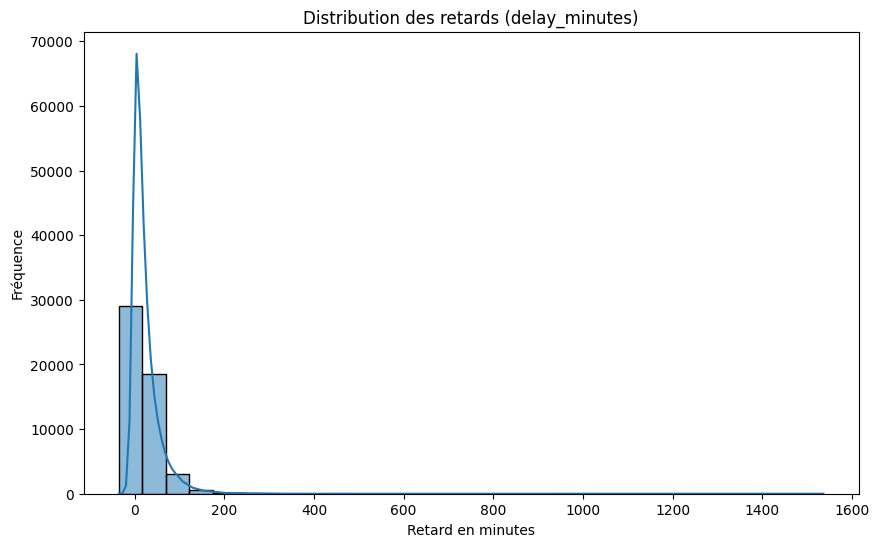

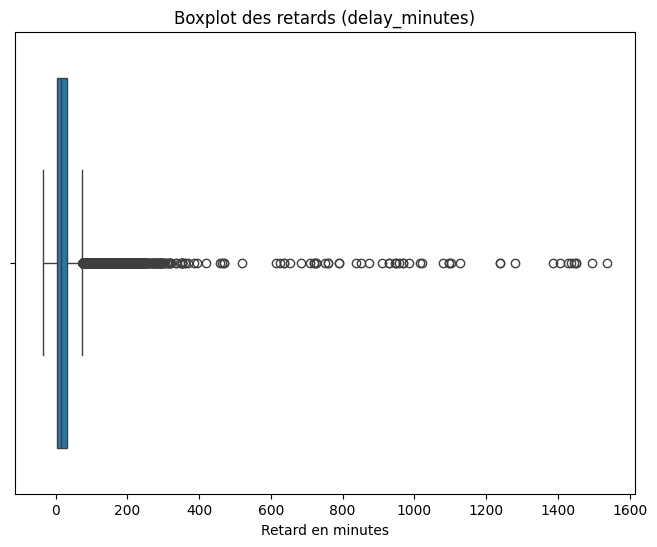

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Statistiques descriptives de la variable de retard
print("Statistiques descriptives de 'delay_minutes':")
print(df_departure['delay_minutes'].describe())

# Distribution des retards
plt.figure(figsize=(10, 6))
sns.histplot(df_departure['delay_minutes'], bins=30, kde=True)
plt.title("Distribution des retards (delay_minutes)")
plt.xlabel("Retard en minutes")
plt.ylabel("Fréquence")
plt.show()

# Boxplot pour visualiser les outliers
plt.figure(figsize=(8, 6))
sns.boxplot(x=df_departure['delay_minutes'])
plt.title("Boxplot des retards (delay_minutes)")
plt.xlabel("Retard en minutes")
plt.show()

## ML

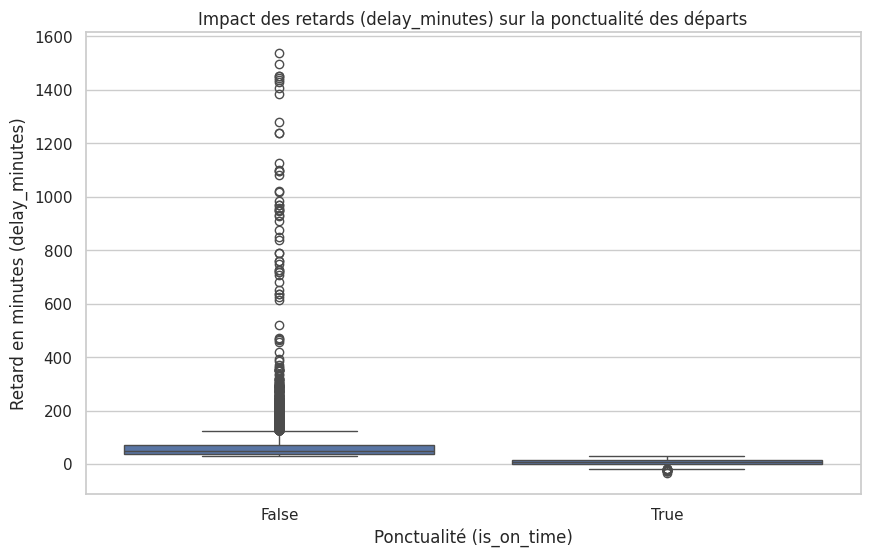

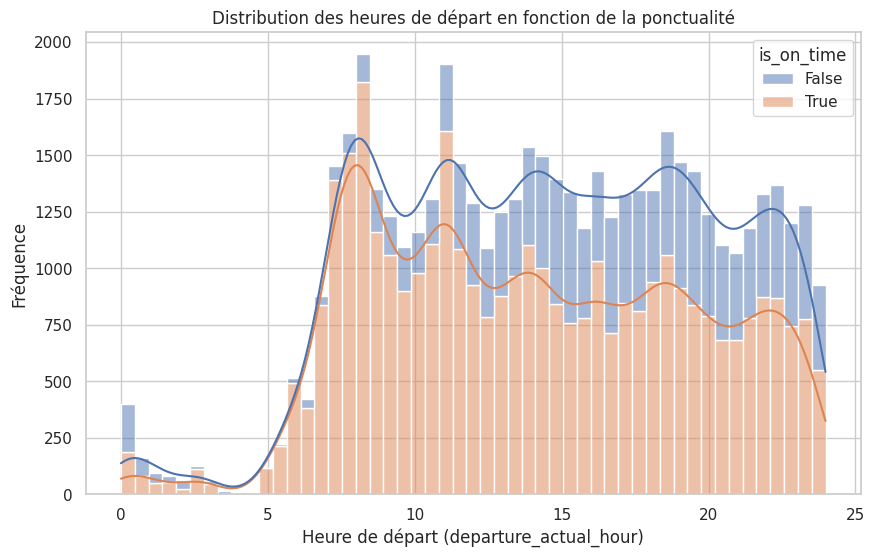

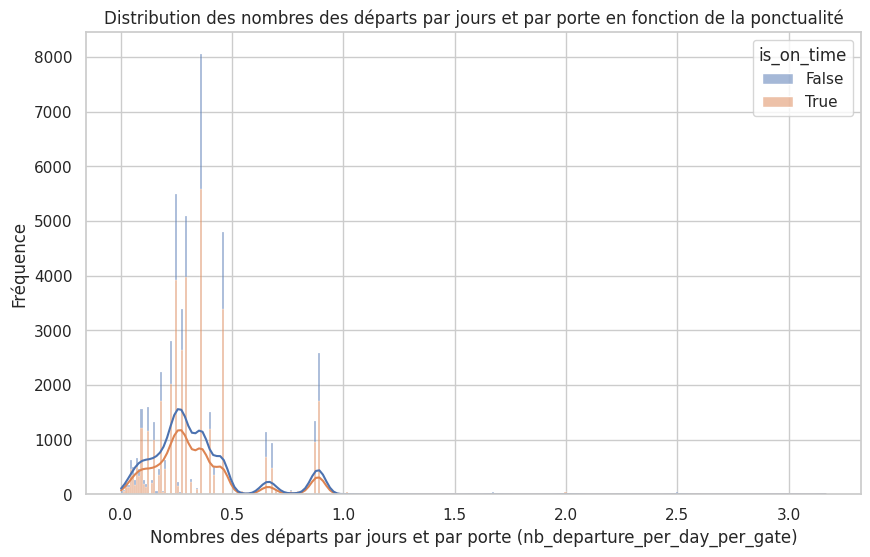

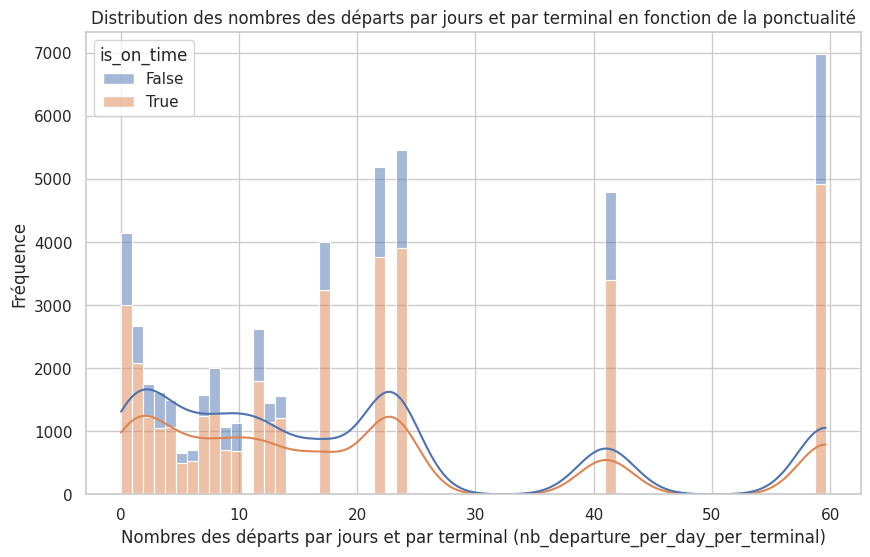

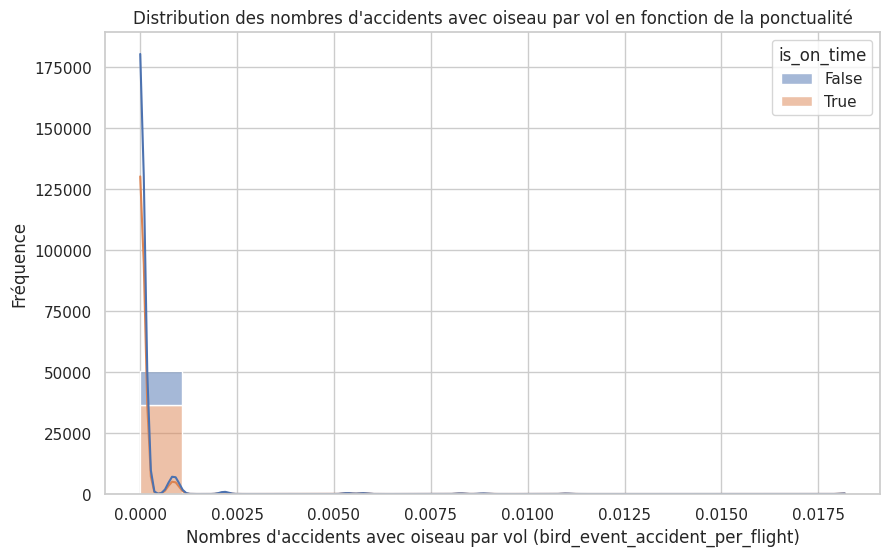

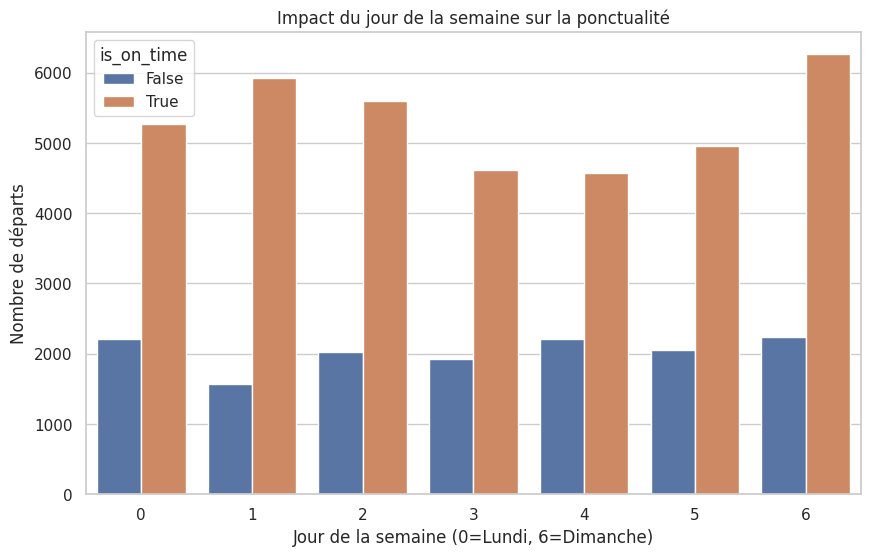

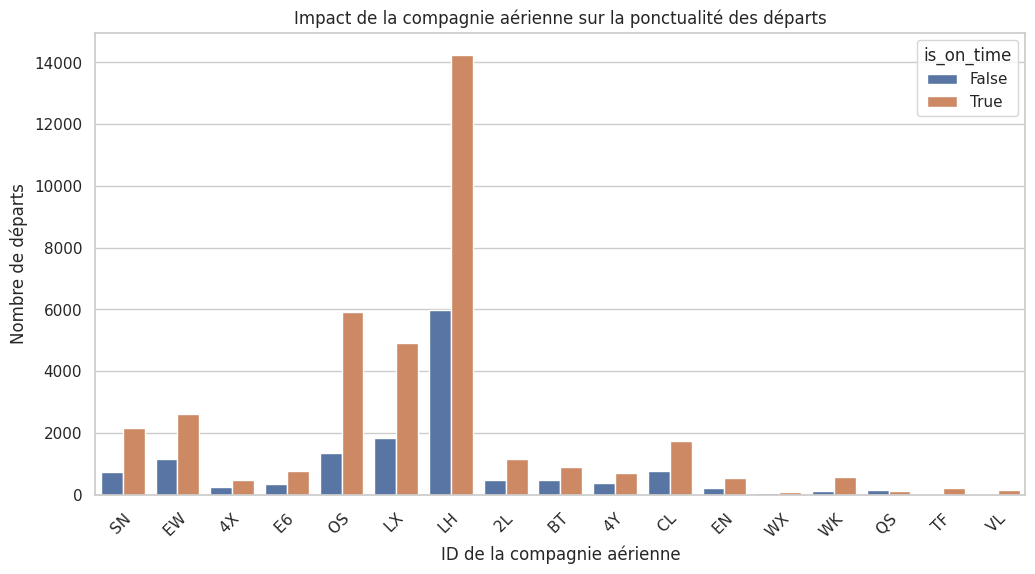

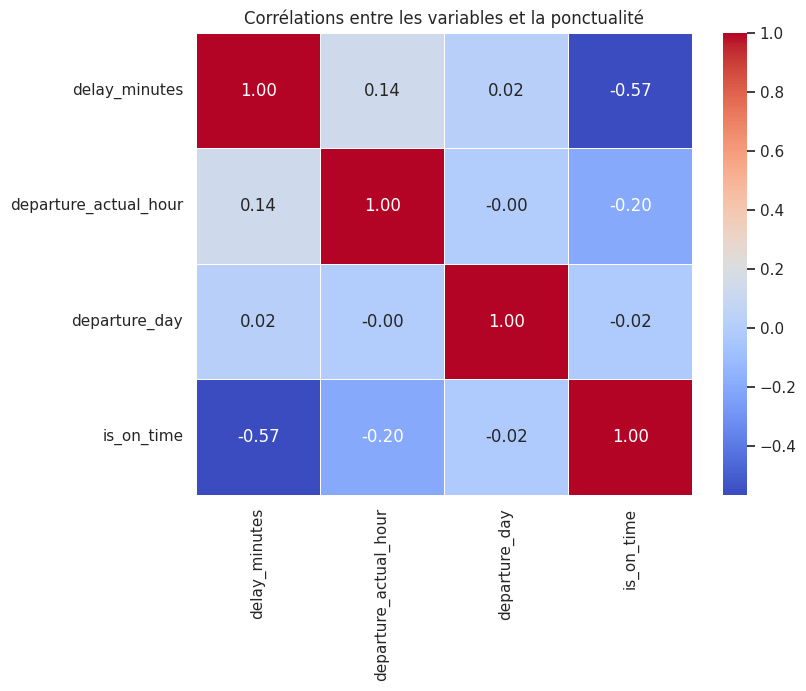

In [13]:
# pip install matplotlib seaborn pandas

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# On suppose que df_departure est déjà créé et contient la colonne 'is_on_time'

# Configuration des styles de graphiques
sns.set(style="whitegrid")

# 1. Boxplot : Analyse de l'impact des retards (delay_minutes) sur 'is_on_time'
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_on_time', y='delay_minutes', data=df_departure)
plt.title("Impact des retards (delay_minutes) sur la ponctualité des départs")
plt.xlabel("Ponctualité (is_on_time)")
plt.ylabel("Retard en minutes (delay_minutes)")
plt.show()

# 2. Distribution des heures de départ (departure_actual_hour) en fonction de 'is_on_time'
plt.figure(figsize=(10, 6))
sns.histplot(data=df_departure, x='departure_actual_hour', hue='is_on_time', multiple='stack', kde=True)
plt.title("Distribution des heures de départ en fonction de la ponctualité")
plt.xlabel("Heure de départ (departure_actual_hour)")
plt.ylabel("Fréquence")
plt.show()

# 3. Distribution des nombres des départs par jours et par porte (nb_departure_per_day_per_gate) en fonction de 'is_on_time'
plt.figure(figsize=(10, 6))
sns.histplot(data=df_departure, x='nb_departure_per_day_per_gate', hue='is_on_time', multiple='stack', kde=True)
plt.title("Distribution des nombres des départs par jours et par porte en fonction de la ponctualité")
plt.xlabel("Nombres des départs par jours et par porte (nb_departure_per_day_per_gate)")
plt.ylabel("Fréquence")
plt.show()

# 4. Distribution des nombres des départs par jours et par terminal (nb_departure_per_day_per_terminal) en fonction de 'is_on_time'
plt.figure(figsize=(10, 6))
sns.histplot(data=df_departure, x='nb_departure_per_day_per_terminal', hue='is_on_time', multiple='stack', kde=True)
plt.title("Distribution des nombres des départs par jours et par terminal en fonction de la ponctualité")
plt.xlabel("Nombres des départs par jours et par terminal (nb_departure_per_day_per_terminal)")
plt.ylabel("Fréquence")
plt.show()

# 5. Distribution des nombres des nombres d'accidents avec oiseau par vol (bird_event_accident_per_flight) en fonction de 'is_on_time'
plt.figure(figsize=(10, 6))
sns.histplot(data=df_departure, x='bird_event_accident_per_flight', hue='is_on_time', multiple='stack', kde=True)
plt.title("Distribution des nombres d'accidents avec oiseau par vol en fonction de la ponctualité")
plt.xlabel("Nombres d'accidents avec oiseau par vol (bird_event_accident_per_flight)")
plt.ylabel("Fréquence")
plt.show()

# 6. Analyse des jours de la semaine sur 'is_on_time' (groupé par 'departure_day')
plt.figure(figsize=(10, 6))
sns.countplot(x='departure_day', hue='is_on_time', data=df_departure)
plt.title("Impact du jour de la semaine sur la ponctualité")
plt.xlabel("Jour de la semaine (0=Lundi, 6=Dimanche)")
plt.ylabel("Nombre de départs")
plt.show()

# 7. Analyse de l'impact de la compagnie aérienne sur 'is_on_time'
plt.figure(figsize=(12, 6))
sns.countplot(x='operating_airline_id', hue='is_on_time', data=df_departure)
plt.title("Impact de la compagnie aérienne sur la ponctualité des départs")
plt.xlabel("ID de la compagnie aérienne")
plt.ylabel("Nombre de départs")
plt.xticks(rotation=45)
plt.show()

# 8. Heatmap des corrélations entre les variables numériques et 'is_on_time'
# Création d'un DataFrame avec les variables numériques pertinentes
df_numeric = df_departure[['delay_minutes', 'departure_actual_hour', 'departure_day']].copy()
df_numeric['is_on_time'] = df_departure['is_on_time'].astype(int)  # Convertir 'is_on_time' en variable numérique

# Calcul des corrélations
corr = df_numeric.corr()

# Affichage de la heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Corrélations entre les variables et la ponctualité")
plt.show()


## Arbre de décision pour les départs pour prédire s'il va y avoir du retard

Précision : 0.75
Matrice de confusion :
[[1578 1256]
 [1361 6091]]
Rapport de classification :
              precision    recall  f1-score   support

 Not On Time       0.54      0.56      0.55      2834
     On Time       0.83      0.82      0.82      7452

    accuracy                           0.75     10286
   macro avg       0.68      0.69      0.68     10286
weighted avg       0.75      0.75      0.75     10286

AUC-ROC : 0.69


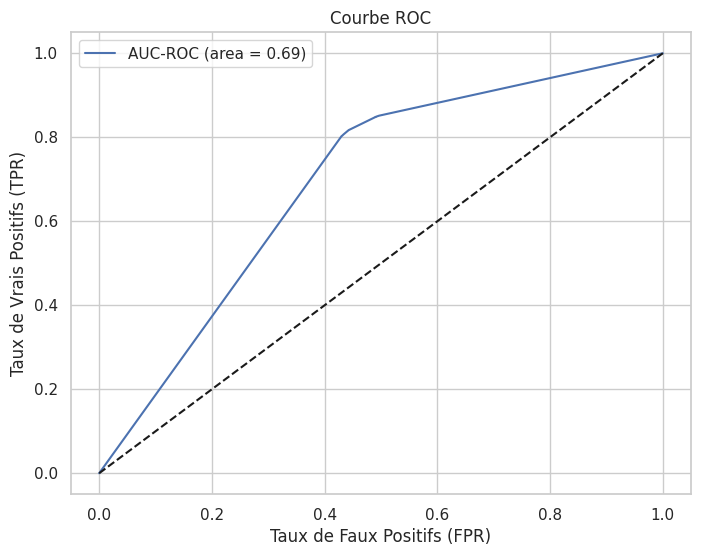

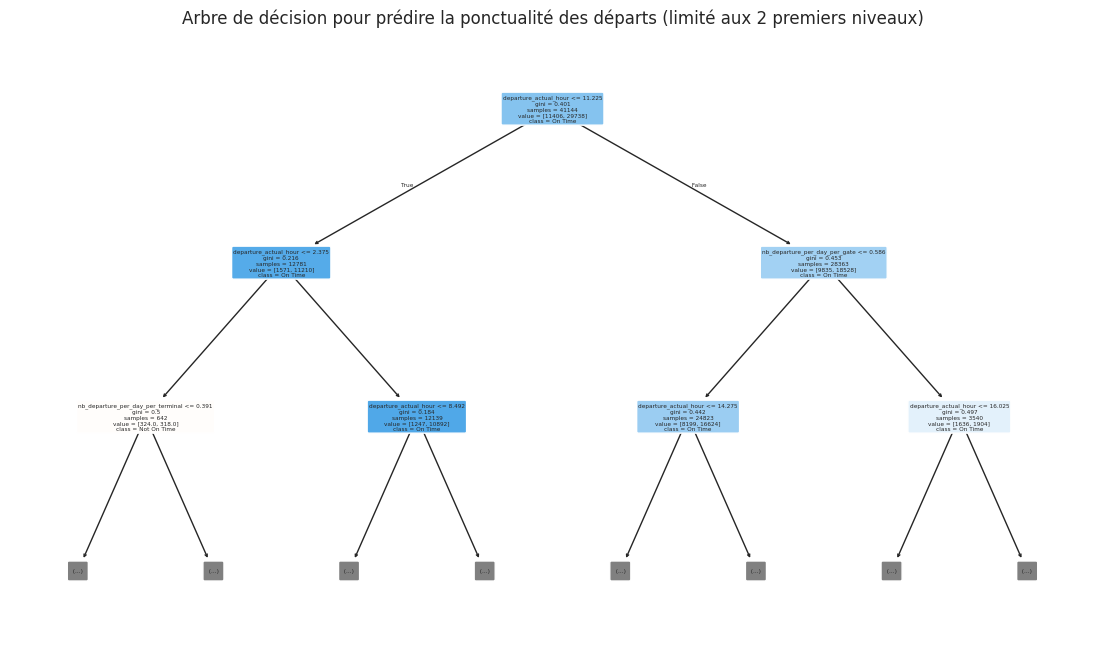

In [14]:
# pip install scikit-learn matplotlib

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

df_to_ml = df_departure[['departure_actual_hour', 'departure_day', 'airport_latitude', 'airport_longitude',
                  'nb_departure_per_day_per_gate', 'nb_departure_per_day_per_terminal',
                  'bird_event_accident_per_flight', 'bird_event_incident_per_flight','is_on_time']]

# 1. Préparation des données : Sélectionner les colonnes pertinentes
X = df_to_ml[['departure_actual_hour', 'departure_day', 'airport_latitude', 'airport_longitude',
                  'nb_departure_per_day_per_gate', 'nb_departure_per_day_per_terminal',
                  'bird_event_accident_per_flight', 'bird_event_incident_per_flight']]

# Variable cible : 'is_on_time'
y = df_to_ml['is_on_time'].astype(int)  # Assurez-vous que 'is_on_time' est un entier (0 ou 1)

# 2. Séparer les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Créer l'arbre de décision
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# 4. Prédictions et évaluation
y_pred = clf.predict(X_test)
# Évaluer la précision
accuracy = accuracy_score(y_test, y_pred)
print(f"Précision : {accuracy:.2f}")

# Afficher la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matrice de confusion :")
print(conf_matrix)

# Rapport de classification
print("Rapport de classification :")
print(classification_report(y_test, y_pred, target_names=['Not On Time', 'On Time']))

# Calcul du score AUC-ROC
y_proba = clf.predict_proba(X_test)[:, 1]  # Probabilités de la classe positive
auc_score = roc_auc_score(y_test, y_proba)
print(f"AUC-ROC : {auc_score:.2f}")

# Tracer la courbe ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC-ROC (area = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Courbe de référence (classificateur aléatoire)
plt.xlabel("Taux de Faux Positifs (FPR)")
plt.ylabel("Taux de Vrais Positifs (TPR)")
plt.title("Courbe ROC")
plt.legend()
plt.show()

# 5. Afficher l'arbre de décision avec une profondeur limitée
plt.figure(figsize=(14, 8))
plot_tree(clf, feature_names=X.columns, class_names=['Not On Time', 'On Time'], filled=True, rounded=True, max_depth=2)
plt.title("Arbre de décision pour prédire la ponctualité des départs (limité aux 2 premiers niveaux)")
plt.show()

## Arbre de décision pour les départs pour prédire le retard en minute

test MSE (Erreur quadratique moyenne) : 1307.4698974541623
Erreur quadratique moyenne en minutes (RMSE) : 36.15895321292034
Comparaison des retards réels et prédits pour les vols de test :
       departure_actual_hour  departure_day  airport_latitude  \
30945              12.066667              4           41.8003   
32215               6.966667              0           52.1658   
22469              23.633333              6           50.0331   
29716              19.650000              1           40.4936   
26747              16.883333              2           37.9364   
34680              15.116667              1           50.0331   
17386               5.833333              1           50.0331   
35668              14.016667              3           47.4647   
28184              17.516667              5           51.2894   
34148              11.200000              0           50.0331   

       airport_longitude  nb_departure_per_day_per_gate  \
30945            12.2389            

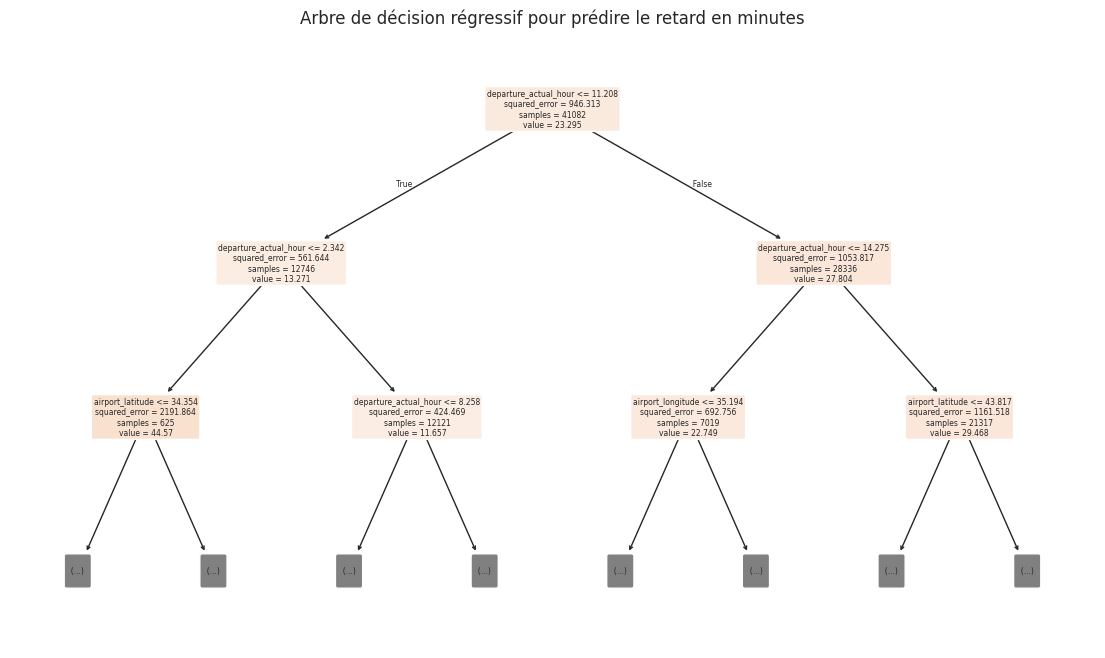

In [15]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# 1. Préparer les données
#X = df_departure[['departure_actual_hour', 'departure_day', 'airport_latitude', 'airport_longitude',
#                  'nb_departure_per_day_per_gate', 'nb_departure_per_day_per_terminal',
#                  'bird_event_accident_per_flight', 'bird_event_incident_per_flight']]
#y = df_departure['delay_minutes'].dropna()  # Retirer les NaN si présents dans le retard

# Filtrer les données pour exclure les retards supérieurs à 300 minutes (outliers)
df_filtered = df_departure[df_departure['delay_minutes'] <= 300]

# Reprendre l'entraînement avec les données filtrées
X = df_filtered[['departure_actual_hour', 'departure_day', 'airport_latitude', 'airport_longitude',
                 'nb_departure_per_day_per_gate', 'nb_departure_per_day_per_terminal']]
y = df_filtered['delay_minutes']

# 2. Séparer les données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Créer et entraîner le modèle de régression par arbre de décision
regressor = DecisionTreeRegressor(random_state=42)
regressor.fit(X_train, y_train)

# 4. Prédictions et évaluation
y_pred = regressor.predict(X_test)
train_mse = mean_squared_error(y_train, y_train)
test_mse = mean_squared_error(y_test, y_pred)
print(f"test MSE (Erreur quadratique moyenne) : {test_mse}")
rmse = np.sqrt(test_mse)
print(f"Erreur quadratique moyenne en minutes (RMSE) : {rmse}")

# 5. Dataframe de vérification
# 5.1 Créer un DataFrame pour comparer le retard prédit et le vrai retard
results_df = X_test.copy()  # On copie X_test pour inclure les mêmes caractéristiques
results_df['Retard Réel (minutes)'] = y_test.values  # Ajouter la colonne de retard réel
results_df['Retard Prédit (minutes)'] = y_pred  # Ajouter la colonne de retard prédit

# 5.2 Afficher les premiers résultats pour comparaison
print("Comparaison des retards réels et prédits pour les vols de test :")
print(results_df.head(10))  # Affiche les 10 premiers vols tests

# 5. Visualiser l'arbre de décision
plt.figure(figsize=(14, 8))
plot_tree(regressor, feature_names=X.columns, filled=True, rounded=True, max_depth=2)
plt.title("Arbre de décision régressif pour prédire le retard en minutes")
plt.show()

## Random Forest

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# 1. Préparer les données

# Filtrer les données pour exclure les retards supérieurs à 300 minutes (outliers)
df_used = df_departure
df_filtered = df_used[df_used['delay_minutes'] <= 300]

# Sélectionner les variables d'entrée
X = df_filtered[['departure_actual_hour', 'departure_day', 'airport_latitude', 'airport_longitude',
                 'nb_departure_per_day_per_gate', 'nb_departure_per_day_per_terminal']]

# Variable cible
y = df_filtered['delay_minutes']

# 2. Séparer les données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Créer et entraîner un modèle Random Forest
rf_regressor = RandomForestRegressor(random_state=42)

# Optimisation des hyperparamètres avec GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# 4. Meilleur modèle après optimisation
best_rf_regressor = grid_search.best_estimator_

# 5. Prédictions et évaluation
y_pred = best_rf_regressor.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred)
print(f"test MSE (Erreur quadratique moyenne) : {test_mse}")
rmse = np.sqrt(test_mse)
print(f"Erreur quadratique moyenne en minutes (RMSE) : {rmse}")

# 6. Dataframe de vérification
# 6.1 Créer un DataFrame pour comparer le retard prédit et le vrai retard
results_df = X_test.copy()  # On copie X_test pour inclure les mêmes caractéristiques
results_df['Retard Réel (minutes)'] = y_test.values  # Ajouter la colonne de retard réel
results_df['Retard Prédit (minutes)'] = y_pred  # Ajouter la colonne de retard prédit

# 6.2 Afficher les premiers résultats pour comparaison
print("Comparaison des retards réels et prédits pour les vols de test :")
print(results_df.head(10))  # Affiche les 10 premiers vols tests

# 7. Visualiser l'importance des caractéristiques
importances = best_rf_regressor.feature_importances_
feature_names = X.columns

plt.figure(figsize=(12, 8))
plt.barh(feature_names, importances)
plt.title("Importance des caractéristiques dans le modèle Random Forest")
plt.xlabel("Importance")
plt.ylabel("Caractéristiques")
plt.show()